In [3]:
import pandas as pd
import numpy as np
import glob

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, auc, make_scorer, roc_auc_score, recall_score, accuracy_score, precision_score, confusion_matrix

import scipy.sparse
from scipy.sparse import csr_matrix, hstack

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.6/site-packages')
from xgboost.sklearn import XGBClassifier

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Reading relevant files

In [2]:
ipb = pd.read_csv("/home/ec2-user/SageMaker/bucket/wiki_trust/ipblocks_fulldump_20190223.txt", sep ='\t')
#ipb = pd.read_csv("ipblocks_fulldump.csv")
ipb = ipb[['ipb_address','date']]
ipb.rename(columns = {'ipb_address':"username",'date':'bl_date'}, inplace=True)
ipb.bl_date = ipb.bl_date.astype('str')
ipb.bl_date = pd.to_datetime(ipb.bl_date)
ipb['ipb_bl'] = 1
print(len(ipb))
ipb.head()

1166572


,username,bl_date,ipb_bl
0,Wanli2,2004-02-08,1
1,Xuepiao,2004-02-08,1
2,GrandVoivodOfErdely,2004-02-08,1
3,#1703,2004-02-13,1
4,Wanli3,2004-03-14,1


In [3]:
files = glob.glob('/home/ec2-user/SageMaker/bucket/wiki_trust/revisions_data/csvs_stored/Blocked/*.csv')
d2=pd.DataFrame()
for file in files:
    d2s = pd.read_csv(file)
    d2 = pd.concat([d2,d2s])
print(d2.shape)
d2.dates = d2.dates.astype('str')
d2.dates = pd.to_datetime(d2.dates).dt.date
d2.dates = pd.to_datetime(d2.dates)
d2.drop(columns=['Unnamed: 0'], inplace=True)
d2.rename(columns={"user":"username","dates":"revision_date"},inplace=True)
d2['bl'] = 1
d2 = d2[~d2.char_changes.str.contains('-')]
print(d2.shape)
d2.tail()

(136783, 6)
(109972, 6)


,char_changes,revision_date,links,username,text,bl
32362,+420,2018-05-24,https://en.wikipedia.org/w/index.php?title=Tal...,Quek157,:PROD = proposed deletion (anyone can challeng...,1
32363,+171,2018-05-24,https://en.wikipedia.org/w/index.php?title=Tal...,Quek157,":::::::thanks, I think you will know who I am ...",1
32364,+924,2018-05-24,https://en.wikipedia.org/w/index.php?title=Tal...,Quek157,"::::::{{reply to|Alexanderlee}}, no problems, ...",1
32365,+46,2018-05-24,https://en.wikipedia.org/w/index.php?title=Tal...,Quek157,":::{{reply to|Snowflake91|Chrissymad}}Good, ac...",1
32366,+571,2018-05-24,https://en.wikipedia.org/w/index.php?title=Tal...,Quek157,":::: I know, I am now exactly talking about so...",1


In [4]:
d2.username.nunique()

19580

In [5]:
files = glob.glob('/home/ec2-user/SageMaker/bucket/wiki_trust/revisions_data/csvs_stored/Non_Blocked/*.csv')
d3=pd.DataFrame()
for file in files:
    d3s = pd.read_csv(file)
    d3 = pd.concat([d3,d3s])
print(d3.shape)
d3.dates = d3.dates.astype('str')
d3.dates = pd.to_datetime(d3.dates).dt.date
d3.dates = pd.to_datetime(d3.dates)
d3.drop(columns=['Unnamed: 0'], inplace=True)
d3.rename(columns={"user":"username","dates":"revision_date"},inplace=True)
d3['bl'] = 0
d3 = d3[~d3.char_changes.str.contains('-')]
print(d3.shape)
d3.tail()

(460269, 6)
(393383, 6)


,char_changes,revision_date,links,username,text,bl
41479,0,2018-08-07,https://en.wikipedia.org/w/index.php?title=Tal...,Tebus19,NaN,0
41480,0,2018-07-30,https://en.wikipedia.org/w/index.php?title=Tal...,Tebus19,NaN,0
41481,0,2018-04-09,https://en.wikipedia.org/w/index.php?title=Tal...,Tebus19,NaN,0
41482,0,2017-09-04,https://en.wikipedia.org/w/index.php?title=Tal...,Tebus19,NaN,0
41483,0,2017-09-04,https://en.wikipedia.org/w/index.php?title=Tal...,Tebus19,NaN,0


In [6]:
d3.username.nunique()

31066

In [7]:
d4 = pd.concat([d2,d3])
print(len(d4))
print(d4.bl.value_counts())
d4.head(10)

503355
0    393383
1    109972
Name: bl, dtype: int64


,char_changes,revision_date,links,username,text,bl
0,+118,2018-01-19,https://en.wikipedia.org/w/index.php?title=Use...,$targlass,Whatever. It's not over.[[User:$targlass|$targ...,1
1,"+1,234",2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{unblock|reason=Как Вы определяете фишинговос...,1
2,+206,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{ping|NeilN}}{{unblock|reason=Извините. Я не ...,1
3,+193,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',"{{unblock|reason=Извините. Я не знал, что доба...",1
5,+149,2018-05-23,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),"::At least I can edit this page. {{ping|JzG}},...",1
6,"+1,800",2018-05-23,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),"::At least I can edit this page. {{ping|JzG}},...",1
7,+130,2018-05-23,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),":Hello, can I still edit my page? [[User:(127....",1
8,+414,2018-05-22,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),:Hi Guy. I don't know why you are accusing me ...,1
9,+110,2012-03-10,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),:::::Thanks! [[User:(127.0.0.1)|(127.0.0.1)]] ...,1
10,+580,2012-03-09,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),:::The first source ''usatoday'' is already re...,1


In [9]:
d4.reset_index(inplace=True)
a1 = pd.DataFrame(d4.links.str.extractall(r'(&oldid=)([\d]*)')[1])
a1.reset_index(inplace=True)
d4['rev_id'] = a1[1]
d4.head()

,index,char_changes,revision_date,links,username,text,bl,rev_id
0,0,+118,2018-01-19,https://en.wikipedia.org/w/index.php?title=Use...,$targlass,Whatever. It's not over.[[User:$targlass|$targ...,1,821350201
1,1,"+1,234",2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{unblock|reason=Как Вы определяете фишинговос...,1,831073982
2,2,+206,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',{{ping|NeilN}}{{unblock|reason=Извините. Я не ...,1,831059743
3,3,+193,2018-03-18,https://en.wikipedia.org/w/index.php?title=Use...,'lllllllllllllllllllllllllllllll',"{{unblock|reason=Извините. Я не знал, что доба...",1,831059095
4,5,+149,2018-05-23,https://en.wikipedia.org/w/index.php?title=Use...,(127.0.0.1),"::At least I can edit this page. {{ping|JzG}},...",1,842665329


In [10]:
print(d4.shape)
d4.rev_id.nunique()

(503355, 8)


475342

### Corpus Creation

In [11]:
db = d4.sort_values(['username','rev_id'],ascending = [True, True])
db.reset_index(inplace=True)
db.drop(['index','links','level_0'],axis=1,inplace=True)
db['dup'] = db.sort_values(['username','rev_id'], ascending = False).groupby(['username','rev_id']).cumcount() + 1
db.head(10)

,char_changes,revision_date,username,text,bl,rev_id,dup
0,+727,2015-08-26,! Bikkit !,== Pentagonal tiling: Colors of sides (Reinhar...,0,677901471,1
1,+289,2015-08-27,! Bikkit !,::Thank you for your answer! And thanks for th...,0,678070719,1
2,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,1
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,1
4,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,1
5,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,1
6,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1
7,+207,2008-09-19,!MNc99,":Very kind, whomever you are. I shall take you...",0,239593352,1
8,+1,2008-09-19,!MNc99,NaN,0,239593409,1
9,+249,2008-10-27,!MNc99,'''If you are reading this page and are about ...,0,248068700,1


In [12]:
db.dup.value_counts()

1    475355
2     28000
Name: dup, dtype: int64

In [13]:
db = db[db.dup==1]
db.drop(['dup'],axis=1,inplace=True)
print(db.shape)

(475355, 6)


In [15]:
db = db.sort_values(['username','revision_date','bl'],ascending = [True, False,False])
db.reset_index(inplace=True)
db.head()

,index,char_changes,revision_date,username,text,bl,rev_id
0,6,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950
1,4,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648
2,5,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872
3,3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098
4,2,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373


In [16]:
db.drop(['index'],axis=1,inplace=True)
db['occurance'] = db.sort_values(['username','revision_date','bl'], ascending = False).groupby('username').cumcount() + 1
db.head(10)

,char_changes,revision_date,username,text,bl,rev_id,occurance
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1
1,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,2
2,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,3
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5
5,+289,2015-08-27,! Bikkit !,::Thank you for your answer! And thanks for th...,0,678070719,6
6,+727,2015-08-26,! Bikkit !,== Pentagonal tiling: Colors of sides (Reinhar...,0,677901471,7
7,+122,2018-01-09,!MNc99,== Genre ==Can I suggest we change the genre o...,0,819463253,1
8,+107,2012-07-23,!MNc99,== Oh In Colour ==Thanks for your continued ex...,0,503812045,2
9,+126,2012-07-23,!MNc99,'''I'm not interested in talking with you.''' ...,0,503814758,3


In [17]:
dbm = pd.merge(db,ipb,left_on='username',right_on='username',how="left")
print(dbm.bl.value_counts())
print(dbm.ipb_bl.value_counts())
dbm.drop(['ipb_bl'], axis=1,inplace=True)
dbm.head()

0    365383
1    109972
Name: bl, dtype: int64
1.0    108339
Name: ipb_bl, dtype: int64


,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1,NaT
1,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,2,NaT
2,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,3,NaT
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4,NaT
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5,NaT


In [18]:
print(dbm.isna().sum())
dbm.bl_date.fillna('2019-01-01',inplace=True)
dbm.dropna(inplace=True)
print(dbm.isna().sum())
dbm.bl_date = pd.to_datetime(dbm.bl_date)
dbm.head()

char_changes          0
revision_date         0
username              0
text              25090
bl                    0
rev_id                0
occurance             0
bl_date          367016
dtype: int64
char_changes     0
revision_date    0
username         0
text             0
bl               0
rev_id           0
occurance        0
bl_date          0
dtype: int64


,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1,2019-01-01
1,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,2,2019-01-01
2,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,3,2019-01-01
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4,2019-01-01
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5,2019-01-01


### Basic EDA

#### Revision count spread

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


         mean  max
bl                
0   13.330741   40
1    5.629040   40


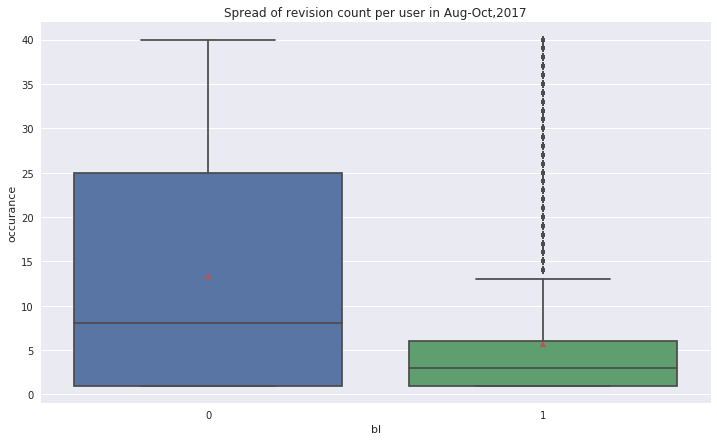

In [19]:
plt1 = pd.DataFrame(dbm.groupby(['username','bl'])['occurance'].agg(lambda x: max(x)))
plt1.reset_index(inplace=True)
print(plt1.groupby('bl')['occurance'].agg({'mean':np.average,'max':max}))
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
h1 = sns.boxplot(x='bl',y='occurance',data=plt1,showmeans=True).set_title('Spread of revision count per user in Aug-Oct,2017')

In [20]:
dbm_cnt = dbm.groupby(['username','bl'])['occurance'].agg({'size1':np.size})
dbm_cnt.reset_index(inplace=True)
print(np.percentile(dbm_cnt[dbm_cnt['bl']==1].size1,[80, 25]))
np.percentile(dbm_cnt[dbm_cnt['bl']==0].size1,[80, 25])
#iqr = np.subtract(*np.percentile(x, [75, 25]))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[8. 1.]


array([26.,  1.])

#### Spread of Active Days - Non Blocked users

(array([3986., 3522., 3744., 3568., 3284., 2834., 2898., 2683., 2607.,
        2698., 2486., 2626., 2656., 2272., 2233., 2415., 2310., 2532.,
        2823., 2646., 2547., 2498., 2315., 2462., 2499., 2469., 2429.,
        2308., 4738.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

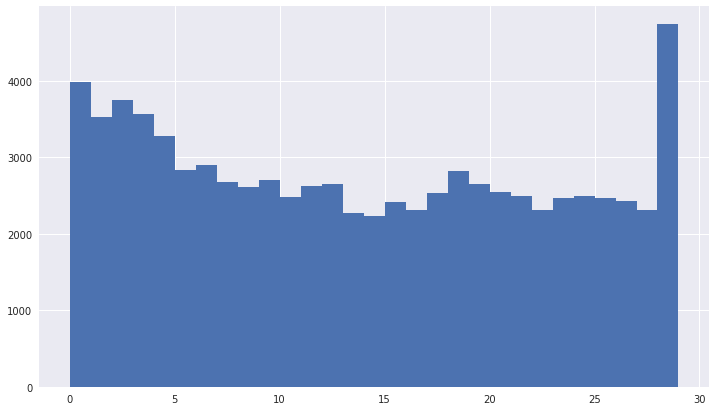

In [21]:
dbm['doi'] = (dbm.bl_date - dbm.revision_date)/7
dbm_b = dbm[dbm['bl']==0]
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
plt.hist(dbm_b.doi.dt.days,bins=np.arange(0,30,1))

#### Spread of Active Days - Blocked users

(array([50253.,  6283.,  3652.,  2924.,  1925.,  1726.,  1435.,  1236.,
         1002.,   841.,   688.,   765.,   723.,   561.,   602.,   531.,
          459.,   527.,   403.,   423.,   355.,   438.,   272.,   359.,
          275.,   250.,   264.,   338.,   568.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

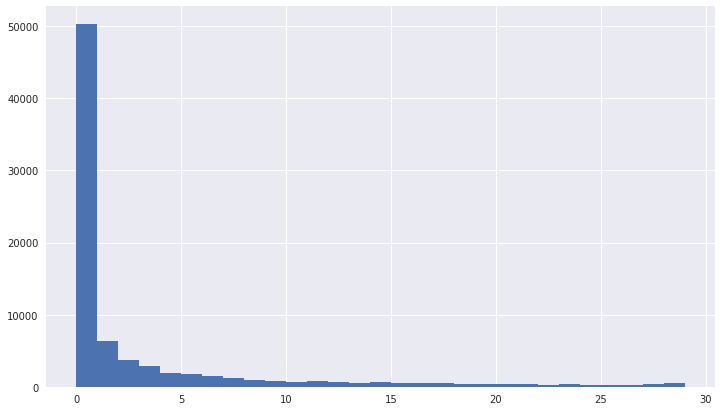

In [22]:
dbm_nb = dbm[dbm['bl']==1]
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
plt.hist(dbm_nb.doi.dt.days,bins=np.arange(0,30,1))

In [23]:
#Filtering data for top-5 comments or comments within one week each
dbm['valid_dt'] = 1
print(len(dbm))
dbm.loc[((dbm.bl==1)&(dbm.doi>'7 days')),'valid_dt']=0
dbm = dbm.loc[(dbm.valid_dt==1)]
print(len(dbm))
print("Count of Non-Blocked comment",len(dbm[dbm['bl']==0]),"\n Count of Blocked comment",len(dbm[dbm['bl']==1]))

450265
412694
Count of Non-Blocked comment 344284 
 Count of Blocked comment 68410


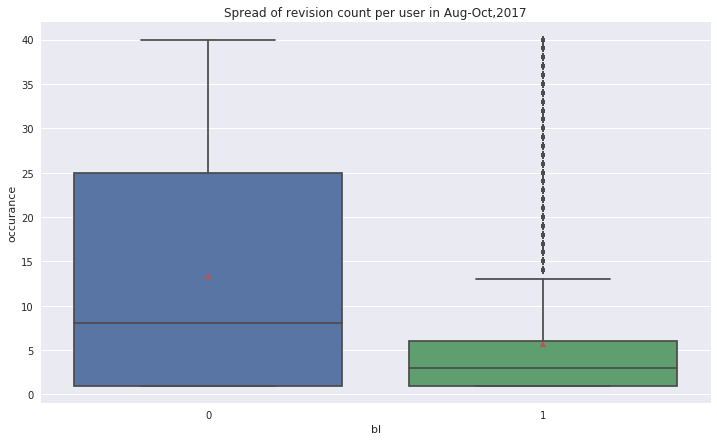

In [24]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
h1 = sns.boxplot(x='bl',y='occurance',data=plt1,showmeans=True).set_title('Spread of revision count per user in Aug-Oct,2017')

In [25]:
dbm = dbm.loc[(dbm.occurance<=5)]
print(len(dbm))
print("Count of Non-Blocked comment",len(dbm[dbm['bl']==0]),"\n Count of Blocked comment",len(dbm[dbm['bl']==1]))
dbm.head()

127783
Count of Non-Blocked comment 89512 
 Count of Blocked comment 38271


,char_changes,revision_date,username,text,bl,rev_id,occurance,bl_date,doi,valid_dt
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,695331950,1,2019-01-01,159 days 00:00:00,1
1,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,695177648,2,2019-01-01,159 days 03:25:42.857142,1
2,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,695241872,3,2019-01-01,159 days 03:25:42.857142,1
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,681751098,4,2019-01-01,171 days 10:17:08.571428,1
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,680954373,5,2019-01-01,172 days 03:25:42.857142,1


In [27]:
dbm.text = dbm.text.astype('str')
dbm = dbm.groupby(['username','bl']).apply(lambda x: " ".join(x.text)).to_frame().rename(columns={0:'text'})
dbm.reset_index(inplace=True)
print(dbm.bl.value_counts())
dbm.head()

0    26923
1    13526
Name: bl, dtype: int64


,username,bl,text
0,! Bikkit !,0,::::In the meantime I learnt that - no matter ...
1,!MNc99,0,== Genre ==Can I suggest we change the genre o...
2,!Silent,0,:@{{U|92.231.176.195}} Thanks! [[User:!Silent|...
3,!dea4u,0,::{{u|Flibirigit}} no i do not feel that it i...
4,!kjjk1992jk!,0,1)\tIndustry Definition\t\tThe bakery industry...


In [28]:
#dbm.to_csv('dbm_b4.txt',sep="\t")

### Feature Engineering + Data Cleaning

In [29]:
dbm.text = dbm.text.str.strip()
dbm.text = dbm.text.str.replace('(\d{1,2}:\d{1,2}, \d{1,2} [A-Za-z]* \d{1,4} \(UTC)\)'," ")
dbm.text = dbm.text.str.replace('({{[\w|\W]*?}})'," ")
dbm.text = dbm.text.str.replace('(\[\[[\w|\W]*?\]\])'," ")
dbm.text = dbm.text.str.replace('(\{\|[\w|\W]*\|\})'," ")
dbm.text = dbm.text.str.replace('(<![\w|\W]*?>)'," ")
dbm.text = dbm.text.str.replace('(<[\w|\W]*?/>)'," ")

In [30]:
dbm['clen'] = dbm.text.str.len()
dbm['numb'] = dbm.text.str.count(r'\d')/dbm['clen']
dbm['caps'] = dbm.text.str.count(r'[A-Z]')/dbm['clen']
dbm['wordlen'] = dbm.text.apply(lambda x: len(str(x).split()))
dbm['schar'] = (dbm.text.str.count(r'\W')-dbm.text.str.count(r'\W\S'))/dbm['clen']
dbm['unique_wlen_percent']=(dbm.text.apply(lambda x: len(set(str(x).split()))))/dbm['wordlen']
dbm['clen_wlen']=dbm['clen']/dbm['wordlen']
dbm.head()

,username,bl,text,clen,numb,caps,wordlen,schar,unique_wlen_percent,clen_wlen
0,! Bikkit !,0,::::In the meantime I learnt that - no matter ...,1771,0.044608,0.057595,222,0.060418,0.729730,7.977477
1,!MNc99,0,== Genre ==Can I suggest we change the genre o...,915,0.000000,0.054645,153,0.072131,0.718954,5.980392
2,!Silent,0,:@ Thanks! ( ),19,0.000000,0.052632,4,0.473684,1.000000,4.750000
3,!dea4u,0,:: no i do not feel that it is not construct...,721,0.018031,0.015257,119,0.074896,0.773109,6.058824
4,!kjjk1992jk!,0,1)\tIndustry Definition\t\tThe bakery industry...,8663,0.020778,0.026088,1385,0.021471,0.443321,6.254874


In [31]:
dbm.text = dbm.text.str.replace('(={2,})'," ")
dbm.text = dbm.text.str.replace('(:{2,})'," ")
dbm.text = dbm.text.str.replace('(\s{2,})'," ")

In [32]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [33]:
#Sentiment analyzer
sentiment_val = dbm.text.apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))

pol_values=[]
for i in sentiment_val:
    pol_val = list(i.values())
    pol_values.append(pol_val)

sent = pd.DataFrame(pol_values)
sent.rename(columns = {0:'neg',1:'neu',2:'pos',3:'compound'}, inplace=True)
sent.drop('pos', axis=1,inplace=True)
sent.head()

,neg,neu,compound
0,0.022,0.871,0.9267
1,0.040,0.872,0.7472
2,0.567,0.000,-0.2244
3,0.072,0.809,0.7783
4,0.027,0.832,0.9994


In [34]:
dbm = pd.merge(dbm,sent,how='inner',left_index=True,right_index=True)
dbm[dbm.neg>0.6].head(10)

,username,bl,text,clen,numb,caps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound
30,(TIB1024H) (Volgren),1,DICK,4,0.0,1.000000,1,0.000000,1.000000,4.000000,1.000,0.000,-0.5106
35,(TPD ACB EMD),1,Blocked Blocked Blocked F*CK ME DADDY OSHWAHH...,70,0.0,0.342857,13,0.200000,0.461538,5.384615,0.612,0.388,-0.6486
119,007Overlord,0,Stop trolling. Stop trolling Stop trolling,42,0.0,0.071429,6,0.023810,0.500000,7.000000,0.688,0.312,-0.6808
561,1.9.216.88,0,Fuck off@,9,0.0,0.111111,2,0.111111,1.000000,4.500000,0.778,0.222,-0.5423
731,101.127.207.162,0,Blocked,16,0.0,0.062500,3,0.375000,0.666667,5.333333,1.000,0.000,-0.2732
733,101.127.209.17,0,It was a mistake Typo error,32,0.0,0.062500,7,0.062500,1.000000,4.571429,0.630,0.370,-0.6249
942,103.1.70.65,0,No? ( ),11,0.0,0.090909,3,0.636364,1.000000,3.666667,1.000,0.000,-0.2960
969,103.14.62.240,0,Fuck you Fuck you,22,0.0,0.090909,5,0.090909,0.800000,4.400000,0.778,0.222,-0.7906
995,103.18.40.202,0,You are a terrorist Pomak,25,0.0,0.080000,5,0.000000,1.000000,5.000000,0.610,0.390,-0.6908
1102,103.224.49.122,0,kill yourself,16,0.0,0.000000,2,0.125000,1.000000,8.000000,0.825,0.175,-0.6908


In [35]:
#Cleaning
print(len(dbm))
dbm.text = dbm.text.str.lower()
dbm.text = dbm.text.str.replace('[^a-zA-Z]'," ")
dbm.text = dbm.text.str.replace(r'\n',' ')
dbm.text = dbm.text.str.replace(r'\s+',' ')
dbm.text = dbm.text.str.replace('([ ]{2,})',' ')
dbm = dbm[~dbm.text.str.match(r'^\s*$')]
dbm = dbm[dbm.text.apply(lambda x:len(x))>10]
print(len(dbm))
dbm.head()

40449
37934


,username,bl,text,clen,numb,caps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound
0,! Bikkit !,0,in the meantime i learnt that no matter what ...,1771,0.044608,0.057595,222,0.060418,0.729730,7.977477,0.022,0.871,0.9267
1,!MNc99,0,genre can i suggest we change the genre of th...,915,0.000000,0.054645,153,0.072131,0.718954,5.980392,0.040,0.872,0.7472
3,!dea4u,0,no i do not feel that it is not constructive ...,721,0.018031,0.015257,119,0.074896,0.773109,6.058824,0.072,0.809,0.7783
4,!kjjk1992jk!,0,industry definition the bakery industry can b...,8663,0.020778,0.026088,1385,0.021471,0.443321,6.254874,0.027,0.832,0.9994
5,!rehtom,0,darren aronofsky larger budget productions th...,1507,0.000000,0.028534,254,0.028534,0.649606,5.933071,0.068,0.821,0.8944


In [36]:
#dbm.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/dbm_after_new_corpus_all_22_02.txt',sep="\t")

In [37]:
#dbm[['username','bl']].to_csv('dbm_user_list_22_02.txt',sep="\t")

### Modeling

In [38]:
def add_feature(X, feature_to_add):
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [39]:
dbm2 = dbm.drop(['bl'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(dbm2, 
                                                    dbm['bl'], 
                                                    random_state=0, test_size=0.25)
len(X_train)

28450

In [40]:
y_train.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/y_train_03_30.txt',sep="\t")
y_test.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/y_test_03_30.txt',sep="\t")

In [57]:
X_train.columns

Index(['username', 'text', 'clen', 'numb', 'caps', 'wordlen', 'schar',
       'unique_wlen_percent', 'clen_wlen', 'neg', 'neu', 'compound'],
      dtype='object')

#### Word n-gram model

In [60]:
vect = TfidfVectorizer(min_df=0.0005,lowercase=True,stop_words='english',norm='l1',ngram_range=(1,2),max_features=1500).fit(X_train['text'])
X_train_word = vect.transform(X_train['text'])
X_test_word = vect.transform(X_test['text'])

In [44]:
dbm.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/dbm_03_30.txt',sep="\t")

#### Character n-gram model

In [61]:
vect_c = TfidfVectorizer(min_df=0.005,lowercase=True,stop_words='english',norm='l1',ngram_range=(2,6),analyzer='char',max_features=5000).fit(X_train['text'])
X_train_char = vect_c.transform(X_train['text'])
X_test_char = vect_c.transform(X_test['text'])

In [62]:
print(X_train_word.shape)
print(X_test_word.shape)

X_train_comb = hstack([X_train_word,X_train_char])
X_test_comb = hstack([X_test_word,X_test_char])

print(X_train_comb.shape)

(28450, 1500)
(9484, 1500)
(28450, 6500)


#### Char + word n-gram + sentiment

In [63]:
print(X_train_comb.shape)
for i in X_train.columns:
    if i != 'text' and i != 'username':
        X_train_comb = add_feature(X_train_comb,X_train[i])
print(X_train_comb.shape)

print(X_test_comb.shape)
for i in X_test.columns:
    if i != 'text' and i != 'username':
        X_test_comb = add_feature(X_test_comb,X_test[i])
print(X_test_comb.shape)        

(28450, 6500)
(28450, 6510)
(9484, 6500)
(9484, 6510)


#### Latent Dirichlet Allocation

In [64]:
lda = LatentDirichletAllocation(n_components=20, max_iter=50,learning_method='online', random_state=0)
#Online faster
lda.fit(X_train_word)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=50, mean_change_tol=0.001,
             n_components=20, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [65]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [66]:
tf_feature_names = vect.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words=10)

Topic #0: balls lmao product obviously thing edited sure event great respect
Topic #1: hi hey math revert sucks alpha style text sign john add
Topic #2: old near files years open site words net probably south
Topic #3: warning man notice wrong september fat wikipedia sex january semi protected
Topic #4: thanks love hate god mistake support sex send work roman
Topic #5: wikipedia wikipedia org org en en wikipedia https en https php index php org index
Topic #6: article discussion nomination fake remove ng policies guidelines son place guidelines
Topic #7: welcome fun includeonly hope happy way play helpful earth welcome wikipedia
Topic #8: fuck hello block help stop sorry blocked like ip account
Topic #9: alpha island police repeatedly span edits characters pro total tr permission
Topic #10: article page wikipedia just thanks like don com edit know
Topic #11: di photo shellwood needs requested pop thank music il readers
Topic #12: edit request protected edit protected semi protected sem

In [67]:
tr_topics = lda.transform(X_train_word)
tt_topics = lda.transform(X_test_word)
tr1 = pd.DataFrame(tr_topics)
tr1.mean(axis=0)

0     0.025682
1     0.026820
2     0.025668
3     0.026461
4     0.026894
5     0.037094
6     0.028400
7     0.027678
8     0.032533
9     0.025523
10    0.429007
11    0.025878
12    0.040214
13    0.030441
14    0.028055
15    0.025712
16    0.026296
17    0.041101
18    0.025904
19    0.044643
dtype: float64

In [68]:
y_train1n = pd.DataFrame(y_train)
y_train1n.reset_index(inplace=True)
y_train1n.drop(columns = ['index'],inplace=True)
y_train1n.head()

,bl
0,0
1,0
2,1
3,0
4,0


In [70]:
xt = pd.DataFrame(X_train_comb.todense())
print(xt.shape)
print(y_train1n.shape)
xt_c = pd.concat([xt,y_train1n],axis=1)
print(xt_c.shape)

(28450, 6510)
(28450, 1)
(28450, 6511)


In [71]:
print(X_train_comb.shape)

X_train_comb1 = hstack([X_train_comb,tr_topics])
X_test_comb1 = hstack([X_test_comb,tt_topics])

print(X_train_comb1.shape)
X_test_comb1.shape

(28450, 6510)
(28450, 6530)


(9484, 6530)

In [72]:
X_test.shape

(9484, 12)

In [73]:
scipy.sparse.save_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_test_unq_mod_03_30.npz', X_test_comb1)
scipy.sparse.save_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_train_unq_mod_03_30.npz', X_train_comb1)

X_test_comb2 = scipy.sparse.load_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_test_unq_detection_03_25.npz')
print(X_test_comb2.shape)
X_train_comb2 = scipy.sparse.load_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_train_unq_detection_03_25.npz')
print(X_train_comb2.shape)

#### Username based features

In [133]:
vect_c1 = TfidfVectorizer(min_df=0.01,lowercase=True,stop_words='english',norm='l1',ngram_range=(2,5),analyzer='char',max_features=300).fit(X_train['username'])
X_train_char1 = vect_c1.transform(X_train['username'])
X_test_char1 = vect_c1.transform(X_test['username'])

In [134]:
print(X_train_comb1.shape)

X_train_comb2 = hstack([X_train_comb1,X_train_char1])
X_test_comb2 = hstack([X_test_comb1,X_test_char1])

print(X_train_comb2.shape)
X_test_comb1.shape

(28450, 6530)
(28450, 6830)


(9484, 6530)

In [135]:
scipy.sparse.save_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_test_unq_mod_userinc_03_30.npz', X_test_comb2)
scipy.sparse.save_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_train_unq_mod_userinc_03_30.npz', X_train_comb2)

### Applying different Machine learning algorithms

#### Using Linear SVM

In [ ]:
x_t = X_train.drop(['username','text','caps_ncaps'],axis=1)
x_t.columns
x_tt = X_test.drop(['username','text','caps_ncaps'],axis=1)
x_tt.columns

In [132]:
lin_clf = LinearSVC(penalty='l1',dual=False)

params = {'C': [0.05, 0.1, 1, 5, 7]}
gs_lin_clf = GridSearchCV(estimator=lin_clf,scoring='accuracy',
                  param_grid=params,
                  n_jobs=-1,
                  cv=2,
                  verbose=3)

gs_lin_clf.fit(X_train_comb, y_train)

best_parameters = gs_lin_clf.best_params_  
print("best parameters are",best_parameters) 

best_result = gs_lin_clf.best_score_  
print("Best Score is",best_result)

predictions_lin_svc = gs_lin_clf.best_estimator_.predict(X_test_comb)

auc1 = roc_auc_score(y_test, predictions_lin_svc)
auc1

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] C=0.05 ..........................................................
[CV] C=0.05 ..........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] ................. C=0.05, score=0.6944815465729349, total=   4.0s
[CV] C=1 .............................................................
[CV] ................. C=0.05, score=0.6970826010544815, total=   4.0s
[CV] C=1 .............................................................
[CV] ................... C=0.1, score=0.704323374340949, total=   5.0s
[CV] C=5 .............................................................
[CV] .................. C=0.1, score=0.7071353251318102, total=   7.4s
[CV] C=5 .............................................................
[CV] .................... C=1, score=0.7343409490333919, total=  11.2s
[CV] C=7 ........

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   41.7s remaining:   17.9s


[CV] .................... C=5, score=0.7377855887521968, total=  38.2s
[CV] .................... C=7, score=0.7364499121265378, total=  27.3s
[CV] ...................... C=7, score=0.73701230228471, total=  39.7s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   57.0s finished


best parameters are {'C': 5}
Best Score is 0.7369068541300527


0.6602949375012226

#### Re-load data sets

In [13]:
y_train = pd.read_csv("/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/y_train_03_30.txt", sep ='\t',header=None)
y_test = pd.read_csv("/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/y_test_03_30.txt", sep ='\t',header=None)
dbm = pd.read_csv("/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/dbm_03_30.txt", sep ='\t')

In [14]:
y_train.rename(columns={0:'index_num',1:'bl'},inplace=True)
y_test.rename(columns={0:'index_num',1:'bl'},inplace=True)
y_train.set_index('index_num',inplace=True)
y_test.set_index('index_num',inplace=True)

In [15]:
print(y_train.shape)
print(y_test.shape)
dbm.shape

(28450, 1)
(9484, 1)


(37934, 14)

In [12]:
y_train.head()

,bl
index_num,
5504,0
16920,0
34777,1
24515,0
22642,0


In [5]:
X_test_comb1 = scipy.sparse.load_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_test_unq_mod_03_30.npz')
print(X_test_comb1.shape)
X_train_comb1 = scipy.sparse.load_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_train_unq_mod_03_30.npz')
print(X_train_comb1.shape)

(9484, 6530)
(28450, 6530)


In [6]:
X_test_comb2 = scipy.sparse.load_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_test_unq_mod_userinc_03_30.npz')
print(X_test_comb2.shape)
X_train_comb2 = scipy.sparse.load_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_train_unq_mod_userinc_03_30.npz')
print(X_train_comb2.shape)

(9484, 6830)
(28450, 6830)


#### Using Logistic Regression

In [75]:
clf = LogisticRegression(penalty='l1')
clf.fit(X_train_comb1, y_train)

params = {'C':[1, 5, 10, 15, 20, 50]}
#C is inverse of regularization strength
gs = GridSearchCV(estimator=clf,
                  param_grid=params,
                  scoring='accuracy',
                  n_jobs=-1,
                  cv=2,
                  verbose=5)
gs.fit(X_train_comb1, y_train)

best_parameters = gs.best_params_  
print("best parameters are",best_parameters) 

best_result = gs.best_score_  
print("Best Score is",best_result)
     
predictions_log = gs.best_estimator_.predict(X_test_comb1)
auc2 = roc_auc_score(y_test, predictions_log)
auc2

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] C=5 .............................................................
[CV] C=5 .............................................................
[CV] .................... C=1, score=0.7202811950790862, total=  11.5s
[CV] C=10 ............................................................
[CV] .................... C=1, score=0.7176801405975396, total=  17.2s
[CV] C=10 ............................................................
[CV] .................... C=5, score=0.7373637961335676, total=  21.8s
[CV] C=15 ............................................................
[CV] ................... C=10, score=0.7376449912126538, total=  17.5s
[CV] C=15 ............................................................
[CV] ..................... C=5, score=0.738207381370826, total=  38.1s
[CV] C=20 .......

[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:  1.4min remaining:   41.5s


[CV] ................... C=20, score=0.7353954305799648, total=  38.8s
[CV] ................... C=20, score=0.7375043936731107, total=  53.8s
[CV] ................... C=50, score=0.7360281195079086, total=  40.1s
[CV] ................... C=50, score=0.7333567662565905, total=  37.2s


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.0min finished


best parameters are {'C': 5}
Best Score is 0.7377855887521968


0.653635797910839

#### Using XGBoost Classifier

In [76]:
xgb = XGBClassifier(n_jobs=-1, silent=0,max_depth=5)

params = {'n_estimators':[500]}
xgb_c = GridSearchCV(estimator=xgb,scoring='accuracy',
                  param_grid=params,
                  n_jobs=-1,
                  cv=2,
                  verbose=1)

xgb_c.fit(X_train_comb1, y_train)

best_parameters = xgb_c.best_params_  
print("best parameters are",best_parameters) 

best_result = xgb_c.best_score_  
print("Best Score is",best_result)

predictions2 = xgb_c.best_estimator_.predict(X_test_comb1)
auc3 = roc_auc_score(y_test, predictions2)
auc3

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[14:06:13] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:06:15] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:06:15] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:06:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:06:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:06:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned 

[14:07:19] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:07:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[14:07:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:07:22] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:07:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[14:07:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:07:26] /opt/conda/conda-bld/xgboost_

[14:08:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[14:08:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[14:08:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[14:08:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[14:08:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[14:08:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[14:08:33] /opt/conda/conda-bld/xgboost_

[14:09:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[14:09:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[14:09:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[14:09:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[14:09:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[14:09:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:09:35] /opt/conda/conda-bld/xgboost_

[14:10:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[14:10:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[14:10:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[14:10:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:10:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[14:10:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:10:40] /opt/conda/conda-bld/xgboost_

[14:11:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[14:11:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[14:11:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:11:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[14:11:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:11:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[14:11:43] /opt/conda/conda-bld/xgboost_

[14:12:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[14:12:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[14:12:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[14:12:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[14:12:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[14:12:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[14:12:45] /opt/conda/conda-bld/xgboost_

[14:13:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[14:13:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:13:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[14:13:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:13:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:13:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:13:49] /opt/conda/conda-bld/xgboost_

[14:14:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:14:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[14:14:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[14:14:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[14:14:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[14:14:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[14:14:51] /opt/conda/conda-bld/xgboost_

[14:15:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[14:15:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[14:15:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[14:15:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:15:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[14:15:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[14:15:53] /opt/conda/conda-bld/xgboost_

[14:16:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[14:16:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[14:16:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[14:16:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:16:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[14:16:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[14:16:56] /opt/conda/conda-bld/xgboost_

[14:17:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[14:17:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[14:17:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[14:17:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[14:17:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[14:17:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[14:17:57] /opt/conda/conda-bld/xgboost_

[14:18:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[14:18:54] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[14:18:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[14:18:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[14:18:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[14:18:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[14:19:00] /opt/conda/conda-bld/xgboost_

[14:19:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[14:19:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[14:19:58] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[14:19:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[14:20:00] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[14:20:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[14:20:02] /opt/conda/conda-bld/xgboost_

[14:20:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[14:20:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[14:21:00] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[14:21:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[14:21:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[14:21:04] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[14:21:05] /opt/conda/conda-bld/xgboost_

[14:22:00] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:22:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[14:22:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[14:22:04] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[14:22:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[14:22:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[14:22:08] /opt/conda/conda-bld/xgboost_

[14:23:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[14:23:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[14:23:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[14:23:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[14:23:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:23:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:23:10] /opt/conda/conda-bld/xgboost_

[14:24:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[14:24:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:24:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[14:24:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[14:24:09] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[14:24:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[14:24:11] /opt/conda/conda-bld/xgboost_

[14:25:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[14:25:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[14:25:09] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[14:25:11] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[14:25:11] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[14:25:13] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[14:25:14] /opt/conda/conda-bld/xgboost_

[14:26:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[14:26:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:26:11] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:26:13] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[14:26:13] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:26:15] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:26:15] /opt/conda/conda-bld/xgboost_

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

[14:26:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:26:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:26:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:26:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:26:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:26:58] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:27:01] /opt/conda/conda-bld/xgboost_

[14:29:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[14:29:04] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:29:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:29:09] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[14:29:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[14:29:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[14:29:17] /opt/conda/conda-bld/xgboost_

[14:31:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[14:31:17] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[14:31:19] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:31:22] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[14:31:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[14:31:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[14:31:29] /opt/conda/conda-bld/xgboost_

[14:33:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:33:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[14:33:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[14:33:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[14:33:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[14:33:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:33:39] /opt/conda/conda-bld/xgboost_

[14:35:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:35:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[14:35:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:35:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[14:35:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[14:35:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[14:35:49] /opt/conda/conda-bld/xgboost_

[14:37:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[14:37:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:37:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[14:37:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[14:37:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[14:37:58] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:38:00] /opt/conda/conda-bld/xgboost_

[14:39:54] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[14:39:58] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[14:40:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[14:40:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[14:40:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[14:40:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[14:40:11] /opt/conda/conda-bld/xgboost_

[14:42:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:42:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[14:42:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[14:42:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[14:42:15] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:42:17] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[14:42:20] /opt/conda/conda-bld/xgboost_

[14:44:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[14:44:17] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[14:44:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[14:44:22] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[14:44:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[14:44:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[14:44:29] /opt/conda/conda-bld/xgboost_

[14:46:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[14:46:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[14:46:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[14:46:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[14:46:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:46:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[14:46:38] /opt/conda/conda-bld/xgboost_

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6825837636848523

#### Using Random Forest Classifier

In [19]:
rf = RandomForestClassifier(oob_score='True',warm_start=True)
params = {'n_estimators':[300]}
gs_w = GridSearchCV(estimator=rf,scoring='accuracy',
                  param_grid=params,
                  n_jobs=-1,
                  cv=2,
                  verbose=5)

gs_w.fit(X_train_comb1, y_train)

best_parameters = gs_w.best_params_  
print("best parameters are",best_parameters) 

best_result = gs_w.best_score_  
print("Best Score is",best_result)

predictions_rf_w = gs_w.best_estimator_.predict(X_test_comb1)
auc4 = roc_auc_score(y_test, predictions_rf_w)
auc4

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] n_estimators=300 ................................................
[CV] n_estimators=300 ................................................


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... n_estimators=300, score=0.7372934973637961, total= 7.8min
[CV] ....... n_estimators=300, score=0.7387697715289983, total= 8.1min


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  8.4min finished
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


best parameters are {'n_estimators': 300}
Best Score is 0.7380316344463972


0.6354379601011978

#### Using Gradient Boosting Classifier

In [18]:
gbf = GradientBoostingClassifier(max_features='auto')

params = {'n_estimators':[500]}
gs_gb_w_c_s = GridSearchCV(estimator=gbf,scoring='accuracy',
                  param_grid=params,
                  n_jobs=-1,
                  cv=2,
                  verbose=5)

gs_gb_w_c_s.fit(X_train_comb1, y_train)

best_parameters = gs_gb_w_c_s.best_params_  
print("best parameters are",best_parameters) 

best_result = gs_gb_w_c_s.best_score_  
print("Best Score is",best_result)

predictions2 = gs_gb_w_c_s.best_estimator_.predict(X_test_comb1)
auc5 = roc_auc_score(y_test, predictions2)
auc5

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] n_estimators=500 ................................................
[CV] n_estimators=500 ................................................


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... n_estimators=500, score=0.7517750439367311, total=46.4min
[CV] ....... n_estimators=500, score=0.7571880492091388, total=46.6min


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 46.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 46.6min finished
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best parameters are {'n_estimators': 500}
Best Score is 0.754481546572935


0.6673613012917066

### XGBoost Classifier

In [13]:
xgb = XGBClassifier(n_jobs=-1, silent=0,max_depth=5)

params = {'n_estimators':[500]}
xgb_c1 = GridSearchCV(estimator=xgb,scoring='accuracy',
                  param_grid=params,
                  n_jobs=-1,
                  cv=2,
                  verbose=1)

xgb_c1.fit(X_train_comb2, y_train)

best_parameters = xgb_c1.best_params_  
print("best parameters are",best_parameters) 

best_result = xgb_c1.best_score_  
print("Best Score is",best_result)

predictions21 = xgb_c1.best_estimator_.predict(X_test_comb2)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A co

[22:16:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:16:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:16:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:16:54] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:16:54] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:16:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:16:57] /opt/conda/conda-bld/xgboost_

[22:17:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:17:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[22:17:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:17:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:18:00] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:18:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:18:02] /opt/conda/conda-bld/xgboost_

[22:19:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:19:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:19:04] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:19:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:19:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[22:19:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[22:19:09] /opt/conda/conda-bld/xgboost_

[22:20:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:20:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:20:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:20:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:20:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[22:20:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[22:20:14] /opt/conda/conda-bld/xgboost_

[22:21:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:21:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:21:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:21:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[22:21:17] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[22:21:17] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[22:21:19] /opt/conda/conda-bld/xgboost_

[22:22:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[22:22:17] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:22:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:22:19] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[22:22:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[22:22:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:22:23] /opt/conda/conda-bld/xgboost_

[22:23:19] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[22:23:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:23:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[22:23:23] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:23:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[22:23:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[22:23:26] /opt/conda/conda-bld/xgboost_

[22:24:22] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:24:23] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[22:24:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[22:24:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[22:24:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[22:24:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:24:29] /opt/conda/conda-bld/xgboost_

[22:25:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[22:25:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[22:25:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[22:25:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[22:25:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[22:25:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[22:25:32] /opt/conda/conda-bld/xgboost_

[22:26:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[22:26:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[22:26:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:26:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[22:26:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:26:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:26:35] /opt/conda/conda-bld/xgboost_

[22:27:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[22:27:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[22:27:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[22:27:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[22:27:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[22:27:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[22:27:38] /opt/conda/conda-bld/xgboost_

[22:28:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[22:28:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[22:28:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[22:28:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:28:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:28:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:28:42] /opt/conda/conda-bld/xgboost_

[22:29:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[22:29:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[22:29:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:29:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[22:29:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[22:29:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[22:29:45] /opt/conda/conda-bld/xgboost_

[22:30:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[22:30:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[22:30:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:30:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:30:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:30:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[22:30:48] /opt/conda/conda-bld/xgboost_

[22:31:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[22:31:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[22:31:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[22:31:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:31:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:31:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[22:31:52] /opt/conda/conda-bld/xgboost_

[22:32:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[22:32:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:32:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:32:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[22:32:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:32:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[22:32:55] /opt/conda/conda-bld/xgboost_

[22:33:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[22:33:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[22:33:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[22:33:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[22:33:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:33:58] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[22:33:58] /opt/conda/conda-bld/xgboost_

[22:34:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[22:34:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[22:34:58] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[22:34:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[22:35:00] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[22:35:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[22:35:02] /opt/conda/conda-bld/xgboost_

[22:35:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:35:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[22:36:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:36:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:36:04] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[22:36:04] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:36:06] /opt/conda/conda-bld/xgboost_

[22:37:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[22:37:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:37:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[22:37:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[22:37:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:37:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[22:37:10] /opt/conda/conda-bld/xgboost_

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

[22:37:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:37:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:37:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:37:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:37:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[22:37:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:37:53] /opt/conda/conda-bld/xgboost_

[22:39:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:39:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:40:00] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:40:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:40:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:40:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:40:10] /opt/conda/conda-bld/xgboost_

[22:42:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:42:11] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:42:13] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[22:42:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:42:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:42:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:42:23] /opt/conda/conda-bld/xgboost_

[22:44:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[22:44:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:44:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[22:44:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:44:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[22:44:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[22:44:36] /opt/conda/conda-bld/xgboost_

[22:46:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[22:46:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:46:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[22:46:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:46:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[22:46:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:46:48] /opt/conda/conda-bld/xgboost_

[22:48:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:48:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:48:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:48:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[22:48:54] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:48:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[22:49:00] /opt/conda/conda-bld/xgboost_

[22:50:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:50:58] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:51:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[22:51:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[22:51:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[22:51:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:51:11] /opt/conda/conda-bld/xgboost_

[22:53:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[22:53:09] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:53:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:53:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[22:53:17] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:53:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:53:22] /opt/conda/conda-bld/xgboost_

[22:55:19] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[22:55:22] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[22:55:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[22:55:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[22:55:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[22:55:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:55:34] /opt/conda/conda-bld/xgboost_

[22:57:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:57:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:57:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[22:57:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[22:57:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[22:57:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[22:57:45] /opt/conda/conda-bld/xgboost_

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


NameError: name 'roc_auc_score' is not defined

In [15]:
auc31 = roc_auc_score(y_test, predictions21)
auc31

0.8310063379041881

In [16]:
predictions_xgb_probab = xgb_c1.predict_proba(X_test_comb2)
predictions_xgb_probab1 = pd.DataFrame(predictions_xgb_probab)
predictions_xgb_probab1.rename(columns={1:'abuse_score'},inplace=True)
predictions_xgb_probab1 = predictions_xgb_probab1[['abuse_score']]
predictions_xgb_probab1.head()

,abuse_score
0,0.514003
1,0.183401
2,0.929640
3,0.570493
4,0.085085


In [17]:
predictions_xgb_probab1.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/predictions_xgb_probab_.83_user_name_inc_03_30.txt',sep="\t")

In [9]:
predictions_xgb_probab1 = pd.read_csv("/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/predictions_xgb_probab_.83_user_name_inc_03_30.txt", sep ='\t')
predictions_xgb_probab1.drop(['Unnamed: 0'],axis=1,inplace=True)
predictions_xgb_probab1.head()
df_predprob = predictions_xgb_probab1.iloc[:,0]
df_predprob.head()

0    0.514003
1    0.183401
2    0.929640
3    0.570493
4    0.085085
Name: abuse_score, dtype: float64

### Threshold Analysis

In [30]:
df_predprob = df_predprob[['abuse_score']]
df_predprob = df_predprob.iloc[:,0]
df_predprob.columns = ['blocked_prob']
df_predprob.head()

0    0.514003
1    0.183401
2    0.929640
3    0.570493
4    0.085085
Name: abuse_score, dtype: float32

In [16]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

p, r, thresholds = precision_recall_curve(y_test, df_predprob)

In [17]:
def adjusted_classes(df_predprob, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in df_predprob]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(df_predprob, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    df_pred = [1 if y >= t else 0 for y in df_predprob]
    accuracy = accuracy_score(y_test, df_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print('\n')
    auc = roc_auc_score(y_test, df_pred)
    print("AUC: %.2f%%" % (auc * 100.0))
    print('\n')
    print("=== Classification Report ===")
    print(classification_report(y_test, df_pred))
    print('\n')

    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg      6186       246
pos      1210      1842
Accuracy: 84.65%


AUC: 78.26%


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.84      0.96      0.89      6432
          1       0.88      0.60      0.72      3052

avg / total       0.85      0.85      0.84      9484





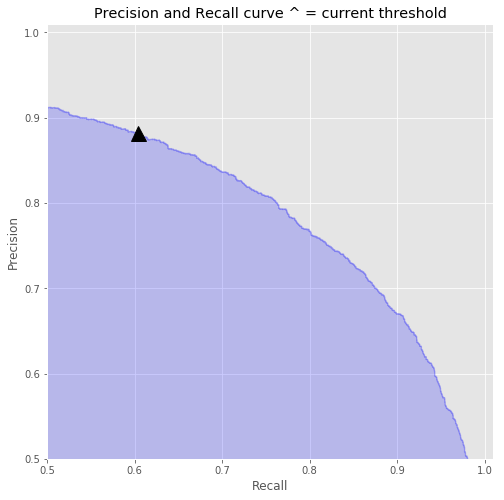

In [23]:
precision_recall_threshold(p,r,thresholds,t=0.7) # original, matches matrix above

#### Using MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state = 9,early_stopping=True, hidden_layer_sizes = (40000,10000,1000,100,),alpha=0.01, activation = 'relu',learning_rate='adaptive',).fit(X_train_comb1, y_train)
predictions_mlp = mlp.predict(X_test_comb1)
auc = roc_auc_score(y_test, predictions_mlp)
auc

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state = 9,early_stopping=True)

params = {'hidden_layer_sizes':[(40000,10000,1000,50),(50000,10000,50)], 'alpha':[.0001, .01], 'activation': ['relu']}
gsmp = GridSearchCV(estimator=mlp,
                  param_grid=params,
                  n_jobs=-1,
                  cv=2,
                  verbose=5)
gsmp.fit(X_train_comb1, y_train)

best_parameters = gsmp.best_params_  
print("best parameters are",best_parameters) 

best_result = gsmp.best_score_  
print("Best Score is",best_result)

predictions_mlp = gsmp.best_estimator_.predict(X_test_comb2)
auc = roc_auc_score(y_test, predictions_mlp)
auc

In [ ]:
scipy.sparse.save_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_test_unq_final_03_29.npz', X_test_comb2)
scipy.sparse.save_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_train_unq_final_03_29.npz', X_train_comb2)

In [ ]:
predictions_xgb = xgb.predict(X_test_comb2)
auc = roc_auc_score(y_test, predictions_xgb)
auc

In [ ]:
predictions2_xgb = pd.DataFrame(predictions_xgb)
predictions2_xgb.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/predictions2_xgb_0.86_03_02.txt',sep="\t")

In [ ]:
xt2 = pd.DataFrame(X_train_comb2.todense())
xtt2 = pd.DataFrame(X_test_comb2.todense())

In [ ]:
X_test1n = X_test.reset_index()
X_test1n.drop(columns = ['index'],inplace=True)
X_test1n.head()
print(xtt2.shape)
xtt2 = pd.concat([X_test1n['username'],xtt2],axis=1)
print(xtt2.shape)
xtt2.head()

In [ ]:
X_train1n = X_train.reset_index()
X_train1n.drop(columns = ['index'],inplace=True)
X_train1n.head()
print(xt2.shape)
xt2 = pd.concat([X_train1n['username'],xt2],axis=1)
print(xt2.shape)
xt2.head()

In [ ]:
xt2.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_train_all_03_02.txt',sep="\t")
xtt2.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_test_all_03_02.txt',sep="\t")

In [ ]:
y_train.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/y_train_all_03_02.txt',sep="\t")
y_test.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/y_test_all_03_02.txt',sep="\t")